In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
import os
import scipy.io as sio
import scipy
import json
from numpy.ma.core import sqrt
import skimage.io as skio
from skimage.measure import label, regionprops, regionprops_table
from skimage.measure import find_contours
from skimage.color import rgba2rgb
from tqdm import tqdm
import graph_tool.all as gt
# conda install jupyter notebook

: 

In [ ]:
!jupyter notebook --allow-root

: 

In [3]:
import openslide

In [4]:
# load images

wsi_basename = '2_4827_A_0045171' #'2_6063_A_0045149'  # '2_4848_A_0039882'
msk = skio.imread('./mask/{}.png'.format(wsi_basename))
img = skio.imread('./thumb/{}.png'.format(wsi_basename))
obj = openslide.OpenSlide(os.path.join('./wsi/'+ wsi_basename + '.svs'))
obj.level_dimensions

((87648, 39584), (21912, 9896), (5478, 2474), (2739, 1237))

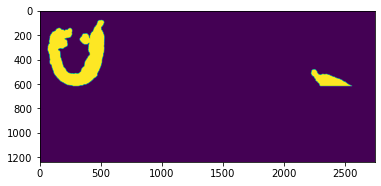

In [5]:
plt.imshow(msk)

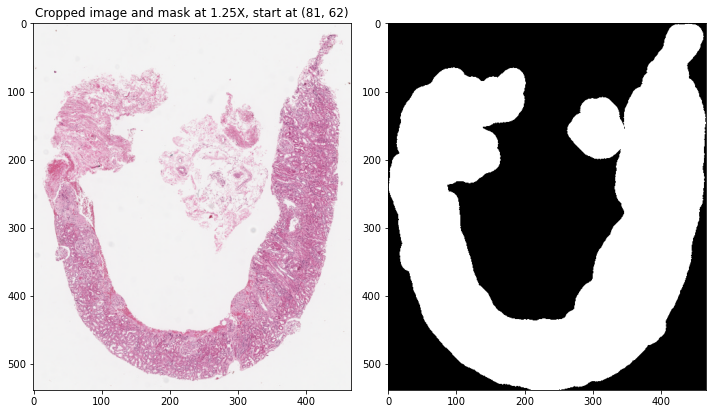

In [6]:
# find lagest regions in mask using regionprops
regions = regionprops(label(msk[:,:]))
largest_region = max(regions, key=lambda region: region.area)
bbox = largest_region.bbox
img_crop = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
msk_crop = msk[bbox[0]:bbox[2], bbox[1]:bbox[3]]
# imshow the cropped image and mask
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_crop)
plt.title('Cropped image and mask at 1.25X, start at {}'.format(bbox[0:2]))
plt.subplot(1,2,2)
plt.imshow(msk_crop, cmap='gray')
#plt.imshow(msk_crop, cmap='gray')
plt.tight_layout()
plt.savefig('./thumb/cropped_mask_{}.png'.format(wsi_basename))

In [7]:
# load the json file (may take ~20 secs)
json_path_wsi = './json/' + wsi_basename + '.json'

bbox_list_wsi = []
centroid_list_wsi = []
contour_list_wsi = [] 
type_list_wsi = []

# add results to individual lists
with open(json_path_wsi) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list_wsi.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list_wsi.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list_wsi.append(inst_bbox)
        inst_type = inst_info['type']
        type_list_wsi.append(inst_type)

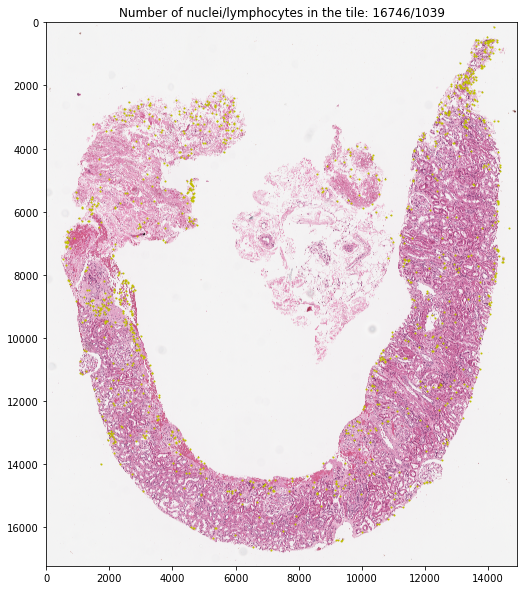

In [8]:
# define the region in original wsi object level 0
x_tile = bbox[1]*32
y_tile = bbox[0]*32
w_tile = (bbox[3] - bbox[1])*32
h_tile = (bbox[2] - bbox[0])*32
# load the wsi object and read/save region
wsi_tile = obj.read_region((x_tile, y_tile), 0, (w_tile,h_tile))
wsi_tile = rgba2rgb(np.array(wsi_tile))
#skio.imsave('./thumb/cropped_{}.png'.format(wsi_basename), wsi_tile.astype('uint8'))

coords_xmin = x_tile
coords_xmax = x_tile + w_tile
coords_ymin = y_tile
coords_ymax = y_tile + h_tile

# collect cells in the region
tile_info_dict = {}
count_tol = 0
count_lym = 0

for idx, cnt in enumerate(contour_list_wsi):
    cnt_tmp = np.array(cnt)
    cnt_tmp = cnt_tmp[(cnt_tmp[:,0] >= coords_xmin) & (cnt_tmp[:,0] <= coords_xmax) & (cnt_tmp[:,1] >= coords_ymin) & (cnt_tmp[:,1] <= coords_ymax)] 
    label = str(type_list_wsi[idx])
    if cnt_tmp.shape[0] > 0:
        cnt_adj = np.round(cnt_tmp - np.array([x_tile,y_tile])).astype('int')
        inst_centroid = centroid_list_wsi[idx]
        inst_centroid = np.round(inst_centroid - np.array([x_tile,y_tile])).astype('int')
        tile_info_dict[idx] = {'contour': cnt_adj.tolist(), 'centroid': inst_centroid.tolist(), 'type':label}
        count_tol += 1
        if label == '2':
            count_lym += 1

# plot the cropped image and the cells, save image and json file
plt.figure(figsize=(10,10))
plt.imshow(wsi_tile)
for idx in tile_info_dict:
    inst_info = tile_info_dict[idx]
    inst_centroid = inst_info['centroid']
    inst_type = inst_info['type']
    if inst_type == '2':
        plt.scatter(inst_centroid[0], inst_centroid[1], c='y',s=1)
plt.title('Number of nuclei/lymphocytes in the tile: {}/{}'.format(count_tol, count_lym))
plt.savefig('./graph/detection_{}.png'.format(wsi_basename), dpi=300)
# save json file
with open('./json/cropped_{}.json'.format(wsi_basename), 'w') as fp:
    json.dump(tile_info_dict, fp)



In [9]:
# create a graph from the centroids of lymphocytes
points = []
for idx in tile_info_dict:
    inst_info = tile_info_dict[idx]
    inst_centroid = inst_info['centroid']
    inst_type = inst_info['type']
    if inst_type == '2':
        x0, y0 = inst_centroid[0], inst_centroid[1]
        points.append([x0,y0])

points = np.array(points)

connect = 300
g, pos = gt.geometric_graph(points[:], connect)
g.set_directed(False)
#edges = g.get_edges()

weight = g.new_edge_property("double")
for e in g.edges():
  weight[e] = np.linalg.norm(pos[e.target()].a - pos[e.source()].a)
tree = gt.min_spanning_tree(g, weights=weight)

u = gt.GraphView(g, efilt=tree)
gt.graph_draw(u, pos=pos, vprops = {"fill_color" : 'yellow', "size" : 1}, eprops = {"pen_width" : 1, "color":'yellow'} , output = "./graph/graph_{}.svg".format(wsi_basename) , fmt = 'svg')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f89e9e9ea90, at 0x7f8a864440d0>